In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [2]:
#read data
df = pd.read_csv('furniture.csv',parse_dates=['Order Date'])

In [3]:
df.head()

Order Date     Sales
0 2014-01-06  2573.820
1 2014-01-07    76.728
2 2014-01-10    51.940
3 2014-01-11     9.940
4 2014-01-13   879.939

In [4]:
df.tail()

Order Date      Sales
884 2017-12-24  1393.4940
885 2017-12-25   832.4540
886 2017-12-28   551.2568
887 2017-12-29  2330.7180
888 2017-12-30   323.1360

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  889 non-null    datetime64[ns]
 1   Sales       889 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.0 KB


In [6]:
df.describe().T

count        mean          std    min     25%     50%      75%  \
Sales  889.0  834.645439  1015.317163  1.988  173.94  493.92  1128.39   

             max  
Sales  10006.174

In [7]:
df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

### Lets do data processing


### 1) Furniture 

In [8]:
# noting the easrlist and last recorded dates
start = df['Order Date'].min()
end = df['Order Date'].max()
print('start =',start, '\nend = ',end)

start = 2014-01-06 00:00:00 
end =  2017-12-30 00:00:00


<AxesSubplot:xlabel='Order Date'>

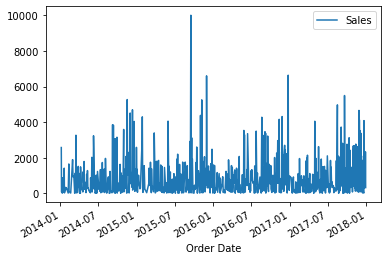

In [9]:
furniture_df = df.sort_values('Order Date')
furniture_df = furniture_df.groupby('Order Date')['Sales'].sum().reset_index()
#setting order date as index
furniture_df = furniture_df.set_index('Order Date')
furniture_df.plot()

<AxesSubplot:xlabel='Order Date'>

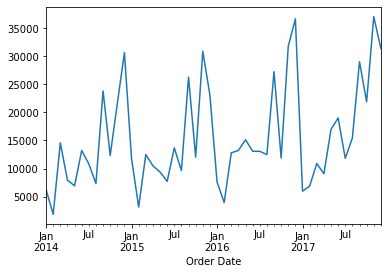

In [10]:
#since there are numerous sales in each month, let's resample the data into tatal monthly sales of furniture and save this into a new variable 
m_furniture = furniture_df['Sales'].resample('M').sum()
m_furniture.plot()

**data is clearly not stationary**

In [57]:
# to confirm preform adf test
from statsmodels.tsa.stattools import adfuller
def test_stationariy(series):
    result = adfuller(series)
    print('adf statistics = ',result[0],'\np value =',result[1])

In [58]:
test_stationariy(m_furniture)

adf statistics =  -4.699026242828903 
p value = 8.450793985809654e-05


p value is higher, data is not stationary.so  Lets make the the data stationary

### lets perform ETS decomposition to under stand the ternd and seasonality componenets


In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
furniture_decom = seasonal_decompose(m_furniture,model='addictive')

Text(0.5, 1.0, 'Furniture decomposition')

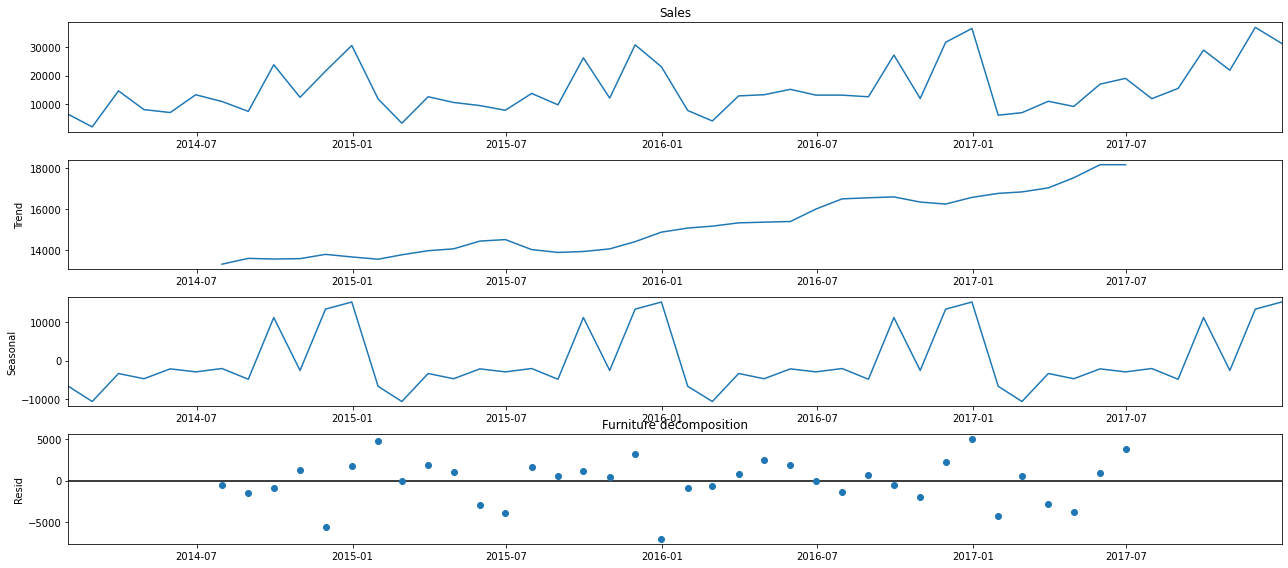

In [14]:
from pylab import rcParams
rcParams['figure.figsize']=18,8
furniture_decom.plot()
plt.title('Furniture decomposition')

There is clearly an upward trent and volatilty we need to fix

<AxesSubplot:xlabel='Order Date'>

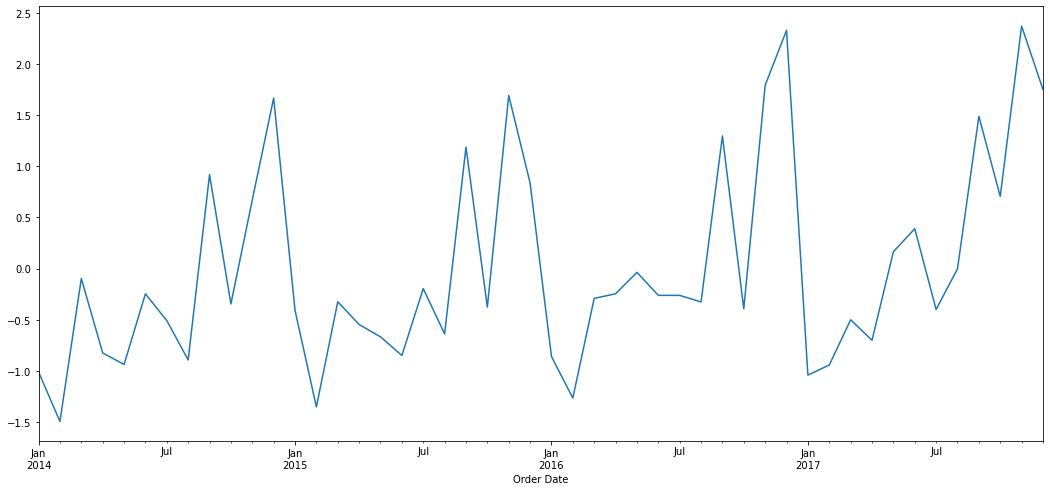

In [15]:
#lets normalize the data
avg,dev = m_furniture.mean(),m_furniture.std()
n_furniture = (m_furniture - avg)/dev
n_furniture.plot()

In [16]:
#taking the first difference to fix the trent
diff_furniture = m_furniture.diff()


<AxesSubplot:xlabel='Order Date'>

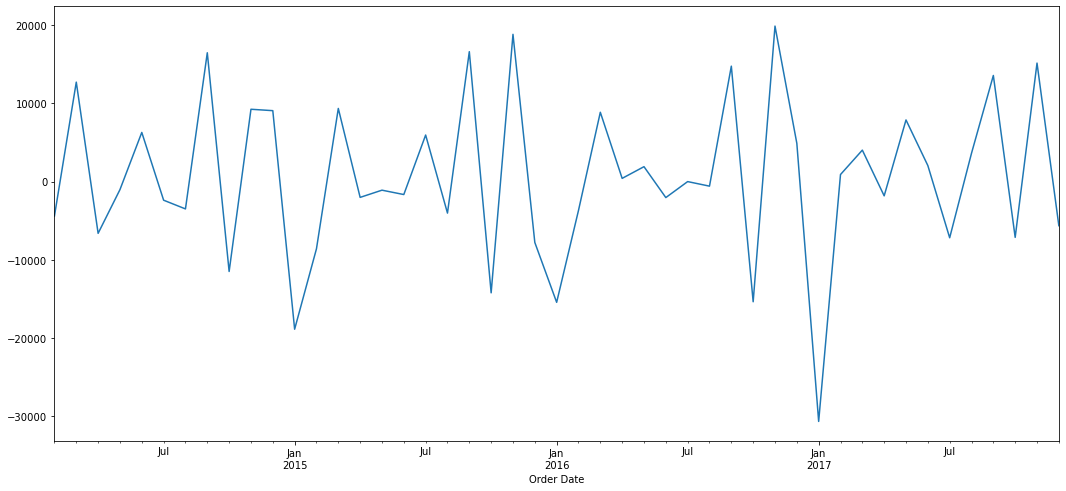

In [17]:
diff_furniture = diff_furniture.dropna()
diff_furniture.plot()

In [18]:
# to fix the volatility
volatility = diff_furniture.groupby(diff_furniture.index.year).std()
volatility

Order Date
2014     8960.178986
2015    11561.016755
2016    10445.598121
2017    12025.075430
Name: Sales, dtype: float64

In [19]:
anual_volatility = diff_furniture.index.map(lambda x: volatility.loc[x.year])
anual_volatility

Float64Index([  8960.17898567253,   8960.17898567253,   8960.17898567253,
                8960.17898567253,   8960.17898567253,   8960.17898567253,
                8960.17898567253,   8960.17898567253,   8960.17898567253,
                8960.17898567253,   8960.17898567253, 11561.016754981922,
              11561.016754981922, 11561.016754981922, 11561.016754981922,
              11561.016754981922, 11561.016754981922, 11561.016754981922,
              11561.016754981922, 11561.016754981922, 11561.016754981922,
              11561.016754981922, 11561.016754981922,  10445.59812069833,
               10445.59812069833,  10445.59812069833,  10445.59812069833,
               10445.59812069833,  10445.59812069833,  10445.59812069833,
               10445.59812069833,  10445.59812069833,  10445.59812069833,
               10445.59812069833,  10445.59812069833, 12025.075430398932,
              12025.075430398932, 12025.075430398932, 12025.075430398932,
              12025.075430398932, 1202

<AxesSubplot:xlabel='Order Date'>

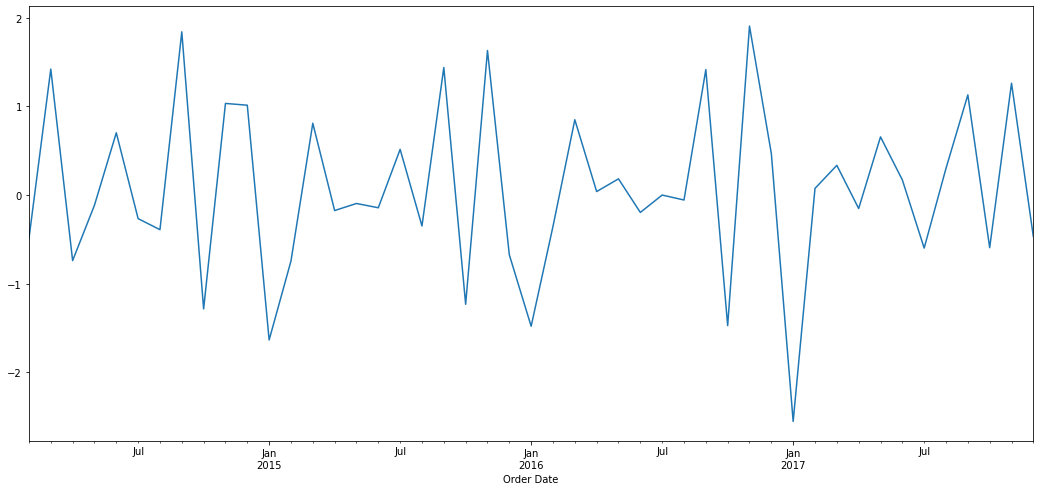

In [20]:
diff_furniture2 = diff_furniture/anual_volatility
diff_furniture2.plot()

In [59]:
# to fix the seasonality
seasonal = diff_furniture2.groupby(diff_furniture2.index.month).mean()
seasonal

Order Date
1    -1.889963
2    -0.378664
3     0.853970
4    -0.256887
5     0.157126
6     0.133273
7    -0.087304
8    -0.123511
9     1.456159
10   -1.146145
11    1.458073
12    0.084521
dtype: float64

<AxesSubplot:xlabel='Order Date'>

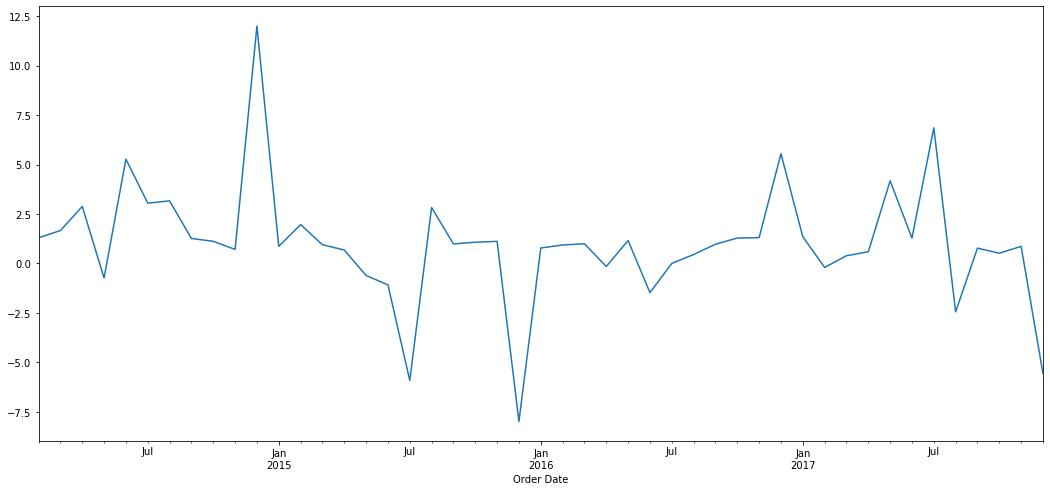

In [22]:
anual_seasonality = diff_furniture2.index.map(lambda x: seasonal.loc[x.month])
stat_furniture = diff_furniture2/anual_seasonality
stat_furniture.plot()

In [51]:
test_stationariy(stat_furniture)

adf statistics =  -6.3622789837341935 
p value = 2.4577374897995365e-08


In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

C:\Users\vasee\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



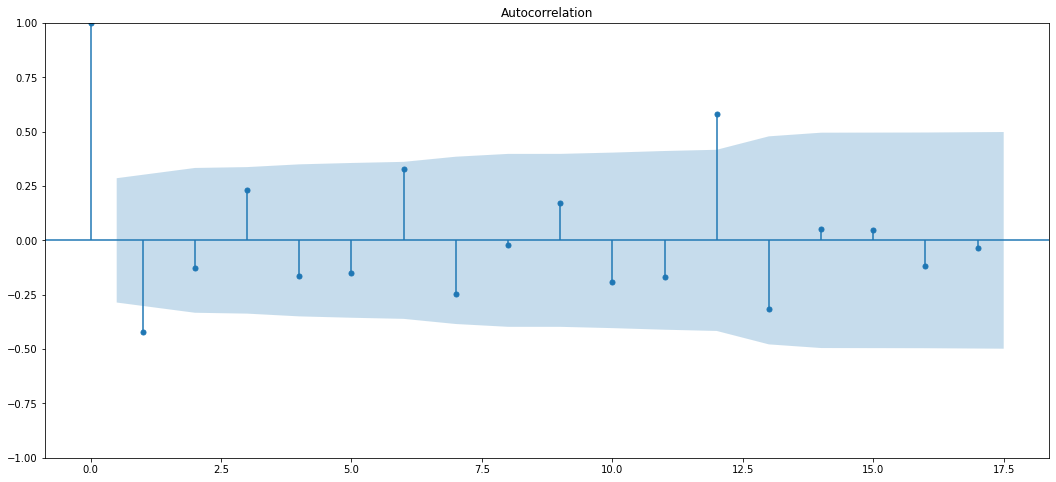

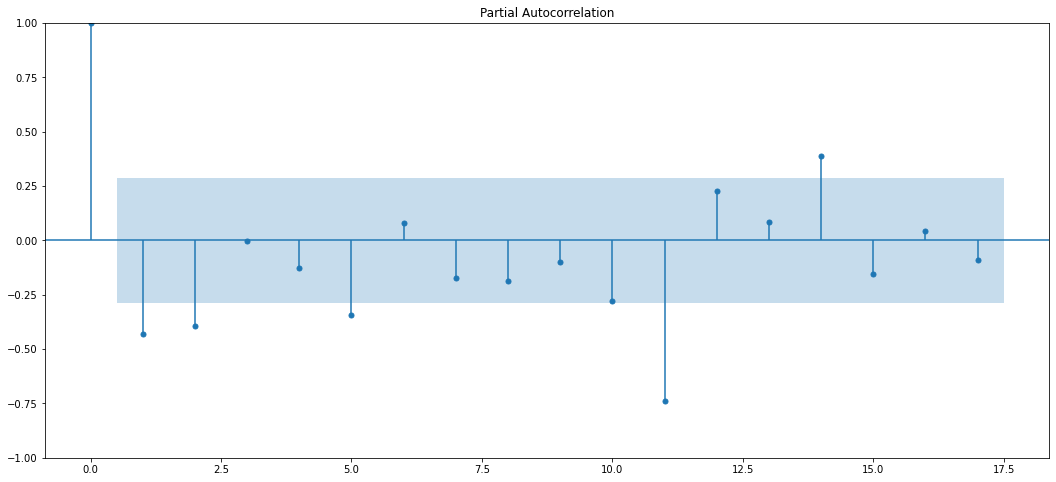

In [62]:
# For furniture
plot_acf(diff_furniture2);
plot_pacf(diff_furniture2);

In [52]:
#seasonality of 12 month at p = 2 , q = 0 

# Time Series Analysis With SARIMA 

lets apply the models to the data. we will be using SARIMA from statsmodels library. To find the best order we will use auto armia. but befor that lets plot acf and pacf to get a rough idea

**Lets apply auto arima to get the best order**

In [66]:
from pmdarima import auto_arima
# for furniture
furniture_order = auto_arima(m_furniture,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=715.201, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=708.796, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=709.325, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=709.756, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=711.529, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=707.976, Time=0.08 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=707.744, Time=0.21 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=709.738, Time=0.36 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=709.855, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=709.579, Time=0.26 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=709.985, Time=0.30 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=711.977, Time=0.41 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=708.710, Time=0.13 sec

Best model:  ARIMA(0,0,0)(2,1,0)[12] intercept
Total fit time: 2.835 seconds


In [26]:
furniture_order.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -349.872
Date:                  Sat, 29 Oct 2022   AIC                            707.744
Time:                          13:56:26   BIC                            714.078
Sample:                      01-31-2014   HQIC                           709.955
                           - 12-31-2017                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1616.5115   1257.009      1.286      0.198    -847.181    4080.205
ar.S.L12      -0.1196      0.087     -1.378      0.168      -0.290       0.051
ar.S.L24       0.1214      0.098      1.240      0.215      -0.070       0.313
sigma2      1.862e+07      0.036    5.1e+08      0.000    1.86e+07    1.86e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.40   Prob(JB):                         0.39
Heteroskedasticity (H):               0.96   Skew:                             0.55
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+25. Standard errors may be unstable.
"""

In [27]:
# splitting the data to train test
furniture_train = m_furniture[:36]
furniture_test = m_furniture[36:]

In [28]:
# Now lets train the model
from statsmodels.tsa.statespace.sarimax import SARIMAX
furniture_mdl = SARIMAX(furniture_train,order=(0, 0, 0),seasonal_order=(2, 1, 0, 12),enforce_invertibility=False)

In [29]:
furniture_model = furniture_mdl.fit()
furniture_model.summary()

C:\Users\vasee\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    Sales   No. Observations:                   35
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -221.953
Date:                  Sat, 29 Oct 2022   AIC                            449.905
Time:                          13:56:26   BIC                            453.312
Sample:                      01-31-2014   HQIC                           450.762
                           - 11-30-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0011      0.039      0.029      0.977      -0.076       0.078
ar.S.L24       0.0997      0.160      0.622      0.534      -0.214       0.414
sigma2      1.327e+07   1.86e-09   7.12e+15      0.000    1.33e+07    1.33e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.49   Prob(JB):                         0.96
Heteroskedasticity (H):               0.64   Skew:                            -0.11
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.5e+31. Standard errors may be unstable.
"""

In [30]:
# Now lets predic with the model
start_date = furniture_test.index[0]
end_date = furniture_test.index[-1]
pred_furniture = furniture_model.predict(start = start_date, end = end_date)

Text(0, 0.5, 'Error')

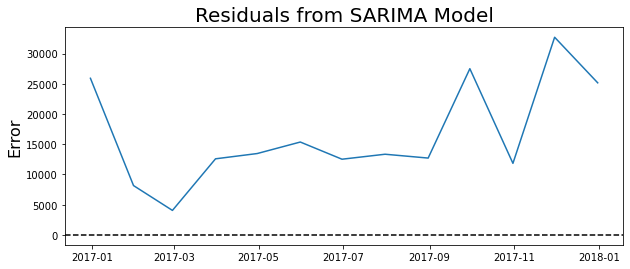

In [31]:
plt.figure(figsize=(10,4))
plt.plot(pred_furniture)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

### Evaluating

In [32]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [33]:
print('mae:',mean_absolute_error(furniture_test,pred_furniture),'\nrmse:',rmse(furniture_test,pred_furniture))

mae: 4334.051406724461 
rmse: 5305.4710866618625


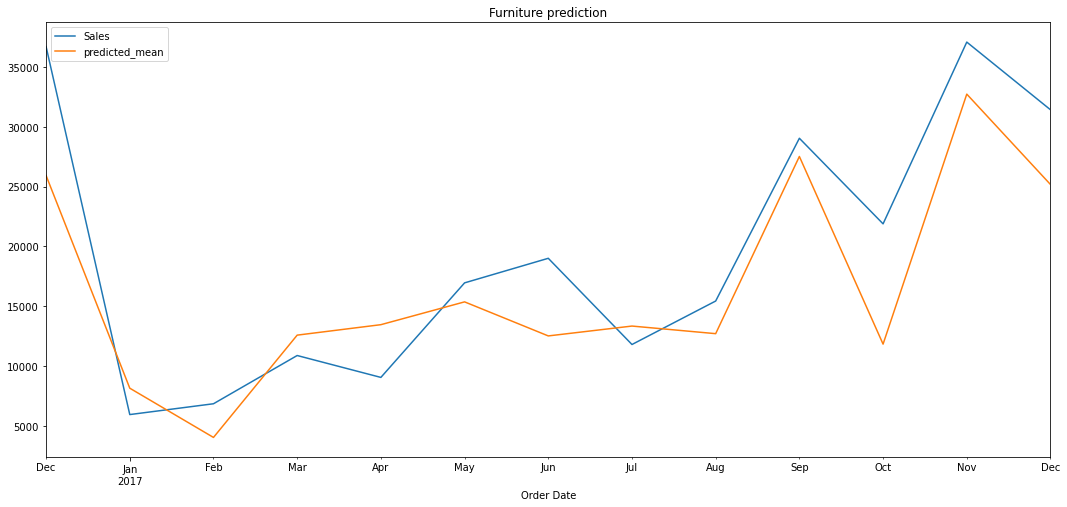

In [34]:
furniture_test.plot()
pred_furniture.plot()
plt.title("Furniture prediction")
plt.legend()

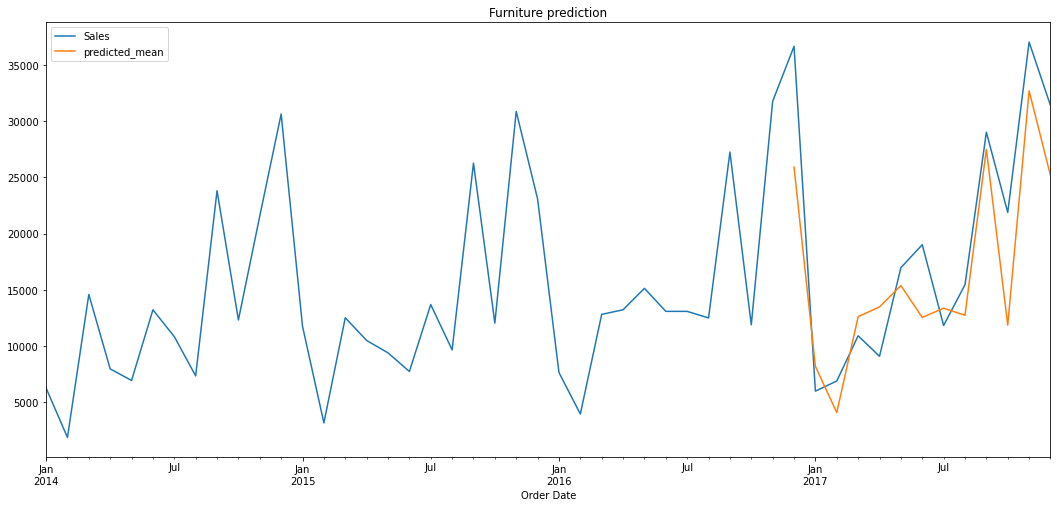

In [35]:
m_furniture.plot()
pred_furniture.plot()
plt.title("Furniture prediction")
plt.legend()

### Now let us forecast into the unknown future

In [36]:
final_fur_model = SARIMAX(m_furniture,order=(0, 0, 0),seasonal_order=(2, 1, 0, 12),enforce_invertibility=False)
furniture_model_final = final_fur_model.fit()
forecast_furniture = furniture_model_final.forecast(steps = 12)

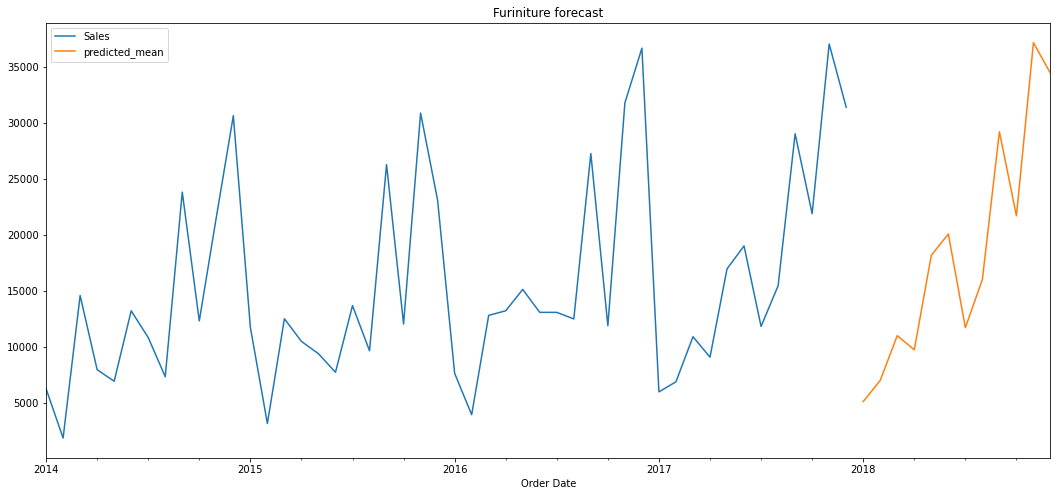

In [37]:
m_furniture.plot()
forecast_furniture.plot()
plt.title("Furiniture forecast")
plt.legend()

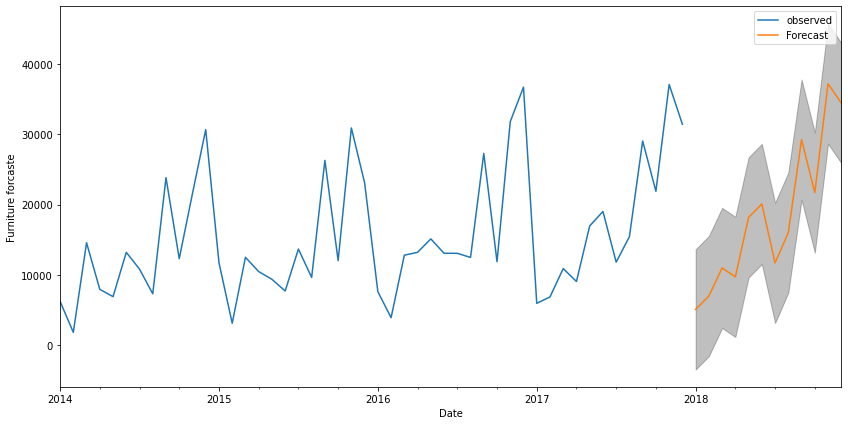

In [38]:
pred_furn = furniture_model_final.get_forecast(steps=12)
pred_ci_furn = pred_furn.conf_int()
ax = m_furniture.plot(label='observed',figsize=(14,7))
pred_furn.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_furn.index,
               pred_ci_furn.iloc[:,0],
               pred_ci_furn.iloc[:,1],color='k',alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture forcaste')
plt.legend()
plt.show()

'''we cant predict white noice'''

# Time series modelling with prophet

In [39]:
p_furniture = pd.DataFrame({'y':m_furniture, 'ds': m_furniture.index})


Lets tryout the facebook prophet model. before thaat lets make the data stationary

In [40]:
p_furniture.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-31 to 2017-12-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       48 non-null     float64       
 1   ds      48 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [41]:
prophet_model = Prophet()

In [42]:
prophet_model.fit(p_furniture)

13:56:29 - cmdstanpy - INFO - Chain [1] start processing
13:56:29 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
forecast_date = prophet_model.make_future_dataframe(periods=12,freq='M')

In [44]:
prophet_forecast = prophet_model.predict(forecast_date)

In [45]:
prophet_forecast

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0  2014-01-31  12475.921296   1665.409019   7637.776679  12475.921296   
1  2014-02-28  12600.204750  -1276.453647   4595.462838  12600.204750   
2  2014-03-31  12737.804288   7797.062004  13850.377532  12737.804288   
3  2014-04-30  12870.965132   4833.434168  10841.663856  12870.965132   
4  2014-05-31  13008.564671   5714.753460  11685.827830  13008.564671   
5  2014-06-30  13141.725516   7096.949708  13368.770671  13141.725516   
6  2014-07-31  13279.325056   7450.142007  13661.752844  13279.325056   
7  2014-08-31  13416.924595   5505.441425  11678.219467  13416.924595   
8  2014-09-30  13550.085438  21524.291156  27686.826738  13550.085438   
9  2014-10-31  13687.684977   9363.285989  15383.706230  13687.684977   
10 2014-11-30  13820.845820  24718.673624  30745.402859  13820.845820   
11 2014-12-31  13958.445359  23645.722634  29420.258659  13958.445359   
12 2015-01-31  14096.044897   4798.480683  10871.468637  14096.044897   
13 2015-02-28  14220.328351    479.788563   6683.298429  14220.328351   
14 2015-03-31  14357.927889  10479.651076  16832.671076  14357.927889   
15 2015-04-30  14491.088733   6382.549300  12470.224251  14491.088733   
16 2015-05-31  14628.688270   5749.774279  12023.366980  14628.688270   
17 2015-06-30  14761.849113   7983.318724  14124.269553  14761.849113   
18 2015-07-31  14899.448650  10537.211908  16864.140000  14899.448650   
19 2015-08-31  15037.048188   6960.114468  13222.050270  15037.048188   
20 2015-09-30  15170.209032  24077.912502  29966.227701  15170.209032   
21 2015-10-31  15307.808572  11607.404781  17393.160824  15307.808572   
22 2015-11-30  15440.982249  26017.009253  31847.101020  15440.982249   
23 2015-12-31  15578.606637  22125.033653  28168.281845  15578.606637   
24 2016-01-31  15716.231026   7946.597446  14143.527034  15716.231026   
25 2016-02-29  15844.977145   1300.089451   7386.530071  15844.977145   
26 2016-03-31  15982.603626   8724.700763  14912.010243  15982.603626   
27 2016-04-30  16115.790542   8004.311824  14191.267898  16115.790542   
28 2016-05-31  16253.442548  12301.588641  18281.255569  16253.442548   
29 2016-06-30  16386.656339  12368.037867  18613.786328  16386.656339   
30 2016-07-31  16524.310590   7991.324343  14044.184056  16524.310590   
31 2016-08-31  16661.964842   9295.788306  15186.278811  16661.964842   
32 2016-09-30  16795.178634  23315.709883  29181.162949  16795.178634   
33 2016-10-31  16932.832886  11218.439409  17414.193977  16932.832886   
34 2016-11-30  17066.046679  28696.378025  34941.086916  17066.046679   
35 2016-12-31  17203.700932  32550.256394  38770.337523  17203.700932   
36 2017-01-31  17341.355184   5100.544109  11127.663980  17341.355184   
37 2017-02-28  17465.688059   3222.702625   9145.395925  17465.688059   
38 2017-03-31  17603.342314  11451.805586  17615.628503  17603.342314   
39 2017-04-30  17736.556109   9773.791188  15715.741032  17736.556109   
40 2017-05-31  17874.210364  12121.402864  18344.767113  17874.210364   
41 2017-06-30  18007.424159  13073.220806  18999.128115  18007.424159   
42 2017-07-31  18145.078414  11249.273947  17041.939820  18145.078414   
43 2017-08-31  18282.732669  10728.951110  16716.090547  18282.732669   
44 2017-09-30  18415.946465  25837.299219  31825.362876  18415.946465   
45 2017-10-31  18553.600720  13829.621158  19628.773706  18553.600720   
46 2017-11-30  18686.814515  30004.521332  36150.863895  18686.814515   
47 2017-12-31  18824.468770  31400.003806  37258.007456  18824.468770   
48 2018-01-31  18962.123025   8244.708176  14137.744371  18962.121865   
49 2018-02-28  19086.455901   5099.470526  11149.809766  19086.452323   
50 2018-03-31  19224.110156  14408.962817  20401.826987  19224.102270   
51 2018-04-30  19357.323951  11176.925996  17175.832048  19357.311808   
52 2018-05-31  19494.978206  12461.731896  18332.337479  19494.960837   
53 2018-06-30  19628.192002  13776.008967  19707.332926  19628.168146

In [46]:
prophet_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [47]:
prophet_forecast[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

ds    yhat_lower    yhat_upper          yhat
48 2018-01-31   8244.708176  14137.744371  11152.354902
49 2018-02-28   5099.470526  11149.809766   8115.760842
50 2018-03-31  14408.962817  20401.826987  17351.397560
51 2018-04-30  11176.925996  17175.832048  14262.611592
52 2018-05-31  12461.731896  18332.337479  15329.263890
53 2018-06-30  13776.008967  19707.332926  16785.923293
54 2018-07-31  14182.702123  20164.048127  17084.024173
55 2018-08-31  12283.119291  18383.970051  15177.263301
56 2018-09-30  28090.589624  34093.046835  31019.518155
57 2018-10-31  15739.264641  22071.040708  18895.247549
58 2018-11-30  31208.401291  37353.096473  34206.840661
59 2018-12-31  30186.832957  36203.461217  33073.802813

In [48]:
from prophet.plot import plot_plotly, plot_components_plotly

In [49]:
plot_plotly(prophet_model, prophet_forecast)

In [50]:
plot_components_plotly(prophet_model , prophet_forecast)